Domain x: (<tf.Tensor: shape=(), dtype=float64, numpy=-3.141592653589793>, <tf.Tensor: shape=(), dtype=float64, numpy=3.141592653589793>)
Domain t: (<tf.Tensor: shape=(), dtype=float64, numpy=0.0>, <tf.Tensor: shape=(), dtype=float64, numpy=6.283185307179586>)
x_train range: -0.9999135004226933 to 0.9999500053880439
t_train range: -0.9999692211472548 to 0.9998620869531658
x_train does not touch boundaries: True
t_train does not touch boundaries: False


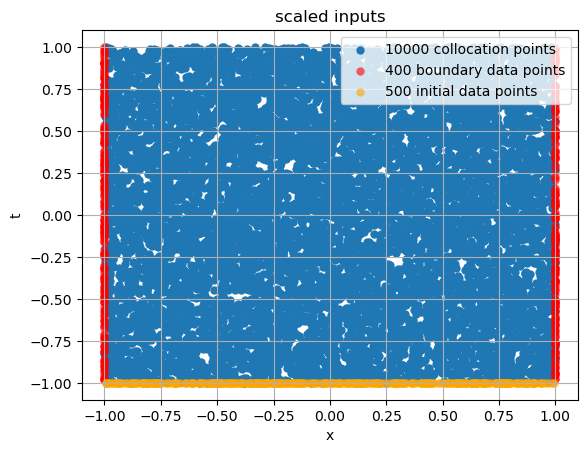

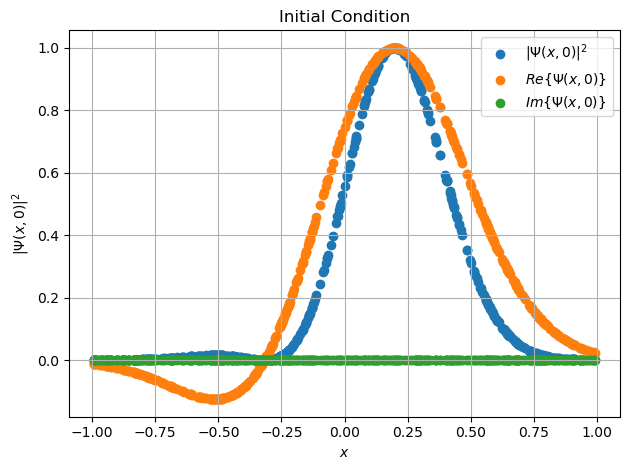

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# from scipy.stats.qmc import LatinHypercube
import time
import datetime

##############################################################################

# Use float64 for higher precision in PDEs
tf.keras.backend.set_floatx('float64')
DTYPE = tf.float64

# inputs
omega = tf.constant(1.0, dtype=DTYPE)
pi = tf.constant(np.pi, dtype=DTYPE)
x_min, x_max = tf.constant(-np.pi, dtype=DTYPE), tf.constant(np.pi, dtype=DTYPE)
t_min, t_max = tf.constant(0.0, dtype=DTYPE), tf.constant(2.0*np.pi, dtype=DTYPE)

def scale_inputs(x, x_min, x_max):
    return 2.0 * (x - x_min) / (x_max - x_min) - 1.0

# initial condition
@tf.function
def psi_init(x, omega, pi):
    u_0 = (omega/pi)**0.25 * tf.math.exp(-0.5*omega*x**2.0)
    u_1 = (omega/pi)**0.25 * tf.math.exp(-0.5*omega*x**2.0) * x *tf.math.sqrt(omega)
    return (1.0/np.sqrt(2.0)) * (u_0 + u_1)

# data generation
N_f, N_b, N_i = 10000, 400, 500
# interior points
x_f = tf.random.uniform((N_f, 1), x_min, x_max, dtype=DTYPE)
t_f = tf.random.uniform((N_f, 1), t_min, t_max, dtype=DTYPE)
x_f = scale_inputs(x_f, x_min, x_max)
t_f = scale_inputs(t_f, t_min, t_max)
# boundary points (// means floor division, e.g., 7//2=3)
x_b = tf.concat([tf.ones((N_b//2, 1), dtype=DTYPE) * x_min,
                 tf.ones((N_b//2, 1), dtype=DTYPE) * x_max
                 ], axis=0)
t_b = tf.random.uniform((N_b, 1), t_min, t_max, dtype=DTYPE)
x_b = scale_inputs(x_b, x_min, x_max)
t_b = scale_inputs(t_b, t_min, t_max)
# initial points
x_i = tf.random.uniform((N_i, 1), x_min, x_max, dtype=DTYPE)
t_i = tf.zeros_like(x_i, dtype=DTYPE)
psi_i = tf.cast(psi_init(x_i, omega, pi), tf.complex128)

psi_real = tf.math.real(psi_i)
psi_imag = tf.math.imag(psi_i)
real_max = tf.reduce_max(tf.abs(psi_real))
psi_real_norm = psi_real / real_max
# imag_max = tf.reduce_max(tf.abs(psi_imag))
# psi_imag_norm = psi_imag / imag_max
psi_i = tf.complex(psi_real_norm, psi_imag)

x_i = scale_inputs(x_i, x_min, x_max)
t_i = scale_inputs(t_i, t_min, t_max)

# Print domain boundary values
print(f"Domain x: {x_min, x_max}")
print(f"Domain t: {t_min, t_max}")

# Check if x_train and t_train are within the boundaries
x_f_min, x_f_max = tf.math.reduce_min(x_f), tf.math.reduce_max(x_f)
t_f_min, t_f_max = tf.math.reduce_min(t_f), tf.math.reduce_max(t_f)

print(f"x_train range: {x_f_min} to {x_f_max}")
print(f"t_train range: {t_f_min} to {t_f_max}")

# Verification
x_within_bounds = (x_f_min > x_min) and (x_f_max < x_max)
t_within_bounds = (t_f_min > t_min) and (t_f_max < t_max)

print(f"x_train does not touch boundaries: {x_within_bounds}")
print(f"t_train does not touch boundaries: {t_within_bounds}")

# plotting collocation and initial points
plt.scatter(x_f, t_f, alpha=1, linewidths=1e-6, label=f'{N_f} collocation points')
plt.scatter(x_b, t_b, color='red', alpha=0.6, linewidths=1e-6, label=f'{N_b} boundary data points')
plt.scatter(x_i, t_i, color='orange', alpha=0.6, linewidths=1e-6, label=f'{N_i} initial data points')
plt.xlabel('x')
plt.ylabel('t')
plt.title('scaled inputs')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# plotting initial condition
plt.scatter(x_i, tf.math.real(psi_i)**2 + tf.math.imag(psi_i)**2, label=r'$|\Psi(x,0)|^2$')
plt.scatter(x_i, tf.math.real(psi_i), label=r'$Re\{\Psi(x,0)\}$')
plt.scatter(x_i, tf.math.imag(psi_i), label=r'$Im\{\Psi(x,0)\}$')
plt.xlabel(r'$x$')
plt.ylabel(r'$|\Psi(x,0)|^2$')
plt.title('Initial Condition')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [2]:
##############################################################################

# Define the Neural Network
@tf.keras.utils.register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, **kwargs):
        super(PINN, self).__init__(**kwargs)
        initializer = tf.keras.initializers.GlorotNormal()
        self.dense1 = tf.keras.layers.Dense(256, activation='tanh', kernel_initializer=initializer)
        self.dense2 = tf.keras.layers.Dense(256, activation='tanh', kernel_initializer=initializer)
        self.dense3 = tf.keras.layers.Dense(256, activation='tanh', kernel_initializer=initializer)
        self.dense4 = tf.keras.layers.Dense(256, activation='tanh', kernel_initializer=initializer)
        self.dense5 = tf.keras.layers.Dense(2, activation='linear', kernel_initializer=initializer) # u_Re, u_Im
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)
        return x
    
    def get_config(self):
        config = super(PINN, self).get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
# We use Hartree atomic units \hbar = m = 1
# Define the Physics Loss
@tf.function
def pde_residual(model, x, t, omega):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([x, t])
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([x, t])
            X = tf.concat([x, t], axis=1)
            uv = model(X)
            u, v = uv[:, 0:1], uv[:, 1:2]
        u_x = tape1.gradient(u, x)
        v_x = tape1.gradient(v, x)
        u_t = tape1.gradient(u, t)
        v_t = tape1.gradient(v, t)
    u_xx = tape2.gradient(u_x, x)
    v_xx = tape2.gradient(v_x, x)
    del tape1, tape2

    potential = 0.5 * omega**2 * x**2

    f_u = -v_t + 0.5*u_xx - potential*u
    f_v = u_t + 0.5*v_xx - potential*v

    return f_u, f_v

@tf.function
def loss_fn(model, interior, boundary, initial, w):
    x_f, t_f = interior
    x_b, t_b = boundary
    x_i, t_i, psi_i = initial
    omega = w

    f_u, f_v = pde_residual(model, x_f, t_f, omega)
    loss_f = tf.reduce_mean(tf.square(f_u) + tf.square(f_v))

    uv_b = model(tf.concat([x_b, t_b], axis=1))
    loss_b = tf.reduce_mean(tf.square(uv_b))

    uv_i = model(tf.concat([x_i, t_i], axis=1))
    loss_i = tf.reduce_mean(tf.square(uv_i[:, 0:1] - tf.math.real(psi_i)) +
                            tf.square(uv_i[:, 1:2] - tf.math.imag(psi_i)))
    
    return loss_f + loss_b + loss_i, (loss_f, loss_b, loss_i)

# Instantiate the Model
pinn = PINN()

with tf.device('/cpu:0'):  # for visibility on some systems
    sample_inputs = tf.concat([x_f[:5], t_f[:5]], axis=1)
    initial_preds = pinn(sample_inputs)
    print("Initial predictions:", initial_preds.numpy())

Initial predictions: [[ 0.05329168 -0.03021983]
 [-0.17133788 -0.06274826]
 [ 0.10026383  0.05399545]
 [ 0.03782502 -0.02998755]
 [ 0.00230119 -0.03352451]]


In [3]:
#############################################################################

# Instantiate the Model
pinn = PINN()

# Define the Optimizer
# Learning rate schedule with exponential decay
initial_learning_rate = 0.001
decay_rate = 0.9
decay_steps = 2000

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

# ADAM optimizer with beta1 = 0.09, beta2 = 0.999 (unusual but from paper)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    clipnorm=1.0
)

# Training Step Function
@tf.function
def train_step(model, x_f, t_f, x_b, t_b, x_i, t_i, psi_i, omega):
    with tf.GradientTape() as tape:
        loss, (lf, lb, li) = loss_fn(model, (x_f, t_f), (x_b, t_b), (x_i, t_i, psi_i), omega)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, (lf, lb, li)

Epoch 0: Loss = 1.85477e-01 (f = 2.07355e-02, b = 3.70813e-03, i = 1.61033e-01)
Model saved to interrupted_Schrodinger_equation_v2.keras
Epoch 100: Loss = 1.46742e-01 (f = 4.38416e-03, b = 1.60554e-02, i = 1.26302e-01)
Model saved to interrupted_Schrodinger_equation_v2.keras
Epoch 200: Loss = 1.16167e-01 (f = 9.00981e-03, b = 1.06357e-02, i = 9.65217e-02)
Model saved to interrupted_Schrodinger_equation_v2.keras
Epoch 300: Loss = 7.26209e-02 (f = 6.92838e-03, b = 6.30536e-03, i = 5.93871e-02)
Model saved to interrupted_Schrodinger_equation_v2.keras
Epoch 400: Loss = 5.60543e-02 (f = 1.25898e-02, b = 8.70306e-03, i = 3.47615e-02)
Model saved to interrupted_Schrodinger_equation_v2.keras
Epoch 500: Loss = 3.76966e-02 (f = 8.76318e-03, b = 6.72841e-03, i = 2.22050e-02)
Model saved to interrupted_Schrodinger_equation_v2.keras
Epoch 600: Loss = 3.28188e-02 (f = 1.00678e-02, b = 8.67740e-03, i = 1.40737e-02)
Model saved to interrupted_Schrodinger_equation_v2.keras
Epoch 700: Loss = 1.73705e-02

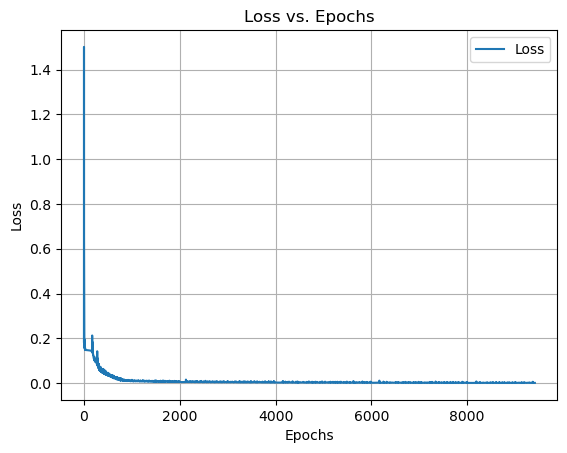

Model saved to Schrodinger_equation_v2.keras

Weights match.
Weights match.
Weights match.
Weights match.
Weights match.
Weights match.
Weights match.
Weights match.
Weights match.
Weights match.
Predictions match.


In [4]:
#############################################################################

# List to store the loss values
loss_history = []
epoch_history = [0,]

# Define the loss threshold
loss_threshold = 1e-3

# Early stopping
early_stopping_patience = 500
best_loss = float('inf')
patience_counter = 0

# Start the timer
start_time = time.time()

# Training Loop until loss < loss_threshold
epoch = 0
while True:
    loss, (lf, lb, li) = train_step(pinn, x_f, t_f, x_b, t_b, x_i, t_i, psi_i, omega)
    loss_value = loss.numpy()
    loss_history.append(loss_value)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.5e} (f = {lf:.5e}, b = {lb:.5e}, i = {li:.5e})")
        
        # Save the model in Keras format
        model_save_path_0 = "interrupted_Schrodinger_equation_v2.keras"
        pinn.save(model_save_path_0)
        print(f"Model saved to {model_save_path_0}")
        
    if loss_value < best_loss:
        best_loss = loss_value
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch} as loss did not improve for {early_stopping_patience} epochs.")
        print(f"Training stopped at epoch {epoch} with loss {loss_value}")
        break
    
    if loss_value < loss_threshold:
        print(f"Training stopped at epoch {epoch} as loss reached {loss_value}")
        break
    
    epoch += 1
    epoch_history.append(epoch)

# End the timer
end_time = time.time()

# Calculate total execution time
execution_time = end_time - start_time

# Convert to hours, minutes, seconds
execution_time_formatted = str(datetime.timedelta(seconds=int(execution_time)))

print(f"Total training time: {execution_time_formatted}")
        
# Plot the Loss vs. Epochs
plt.plot(epoch_history, loss_history, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Save the model in Keras format
model_save_path = "Schrodinger_equation_v2.keras"
pinn.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Save original weights
original_weights = pinn.get_weights()

# Load the model
loaded_pinn = tf.keras.models.load_model(model_save_path, custom_objects={'PINN': PINN})

# Check if the weights match
loaded_weights = loaded_pinn.get_weights()

for orig, loaded in zip(original_weights, loaded_weights):
    if not np.array_equal(orig, loaded):
        print("Weights do not match after loading!")
    else:
        print("Weights match.")

# Check prediction consistency
x_test = np.linspace(x_min, x_max, 100).reshape(-1,1).astype(np.float64)
t_test = np.linspace(t_min, t_max, 100).reshape(-1,1).astype(np.float64)

x_test_tensor = tf.convert_to_tensor(x_test)
t_test_tensor = tf.convert_to_tensor(t_test)

original_prediction = pinn(tf.concat([x_test_tensor, t_test_tensor], axis=1)).numpy()
loaded_prediction = loaded_pinn(tf.concat([x_test_tensor, t_test_tensor], axis=1)).numpy()

if not np.allclose(original_prediction, loaded_prediction, atol=1e-5):
    print("Predictions do not match after loading!")
else:
    print("Predictions match.")

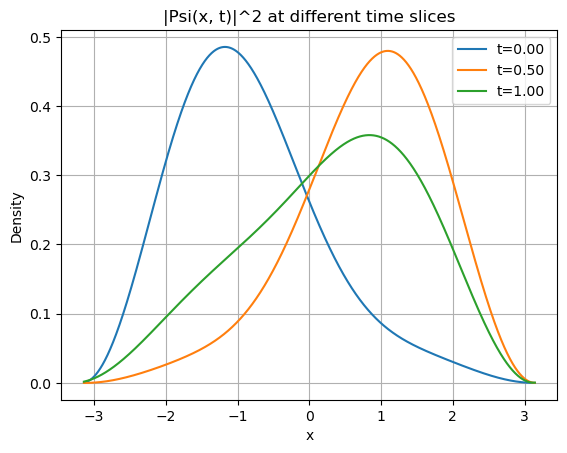

In [ ]:
# # data generation
# N_f, N_b, N_i = 10000, 400, 500
# # interior points
# x_f = tf.random.uniform((N_f, 1), x_min, x_max, dtype=DTYPE)
# t_f = tf.random.uniform((N_f, 1), t_min, t_max, dtype=DTYPE)
# x_f = scale_inputs(x_f, x_min, x_max)
# t_f = scale_inputs(t_f, t_min, t_max)

# x_min, x_max = -np.pi, np.pi
x_min, x_max = tf.constant(-np.pi, dtype=DTYPE), tf.constant(np.pi, dtype=DTYPE)

# Evaluation grid and plotting
def plot_solution(model, time_slices):
    for t_val in time_slices:
        x_f = np.linspace(x_min, x_max, 10000)
        x_f_scaled = scale_inputs(x_f, x_min, x_max)
        t_plot = np.full_like(x_f, t_val)
        X_plot = tf.convert_to_tensor(np.stack([x_f_scaled, t_plot], axis=1), dtype=DTYPE)
        uv = model(X_plot)
        u, v = uv[:, 0], uv[:, 1]
        density = u**2 + v**2

        plt.plot(x_f, density, label=f't={t_val:.2f}')

    plt.title("|Psi(x, t)|^2 at different time slices")
    plt.xlabel("x")
    plt.ylabel("Density")
    plt.legend()
    plt.grid()
    plt.show()

# Plot solution at specific time slices
time_slices = [0.0, 0.5, 1.0]
plot_solution(pinn, time_slices)

Model loaded successfully


Model: "pinn_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_65 (Dense)                │ (10000, 256)           │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (10000, 256)           │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (10000, 256)           │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (10000, 256)           │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (10000, 2)             │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,658 (1.52 MB)

 Trainable params: 198,658 (1.52 MB)

 Non-trainable params: 0 (0.00 B)

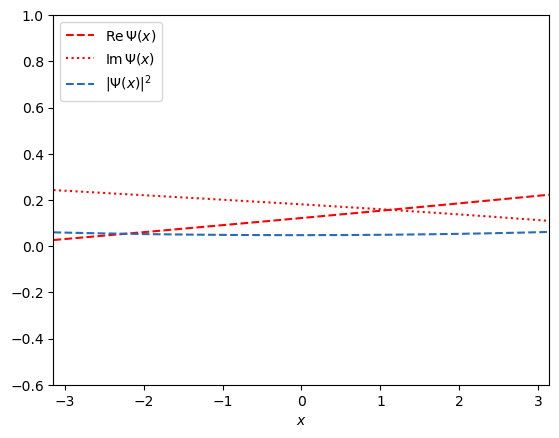

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

x_min, x_max = tf.constant(-np.pi, dtype=DTYPE), tf.constant(np.pi, dtype=DTYPE)
t_min, t_max = tf.constant(0, dtype=DTYPE), tf.constant(2*np.pi, dtype=DTYPE)

# # data generation
# N_f, N_b, N_i = 10000, 400, 500
# # interior points
# x_f = tf.random.uniform((N_f, 1), x_min, x_max, dtype=DTYPE)
# t_f = tf.random.uniform((N_f, 1), t_min, t_max, dtype=DTYPE)
# x_f_scaled = scale_inputs(x_f, x_min, x_max)
# t_f_scaled = scale_inputs(t_f, t_min, t_max)

# Define the Neural Network
@tf.keras.utils.register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, **kwargs):
        super(PINN, self).__init__(**kwargs)
        initializer = tf.keras.initializers.HeNormal()
        self.dense1 = tf.keras.layers.Dense(256, activation='tanh', kernel_initializer=initializer)
        self.dense2 = tf.keras.layers.Dense(256, activation='tanh', kernel_initializer=initializer)
        self.dense3 = tf.keras.layers.Dense(256, activation='tanh', kernel_initializer=initializer)
        self.dense4 = tf.keras.layers.Dense(256, activation='tanh', kernel_initializer=initializer)
        self.dense5 = tf.keras.layers.Dense(2, activation='linear', kernel_initializer=initializer) # u_Re, u_Im
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)
        return x
    
    def get_config(self):
        config = super(PINN, self).get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Load the model
loaded_model = tf.keras.models.load_model('Schrodinger_equation_v2.keras', custom_objects={'PINN': PINN})
print("Model loaded successfully")

loaded_model.summary()

# Set up the figure and axis
fig, ax = plt.subplots()
ax.set_xlim(x_min, x_max)
ax.set_ylim(-0.6, 1.0)
ax.set_xlabel(r'$x$')

# Plot elements
line_real, = ax.plot([], [], "--r", label=r'$\mathrm{Re}\, \Psi(x)$')
line_imag, = ax.plot([], [], ":r", label=r'$\mathrm{Im}\, \Psi(x)$')
line_prob, = ax.plot([], [], "--", color="#266bbd", label=r'$|\Psi(x)|^2$')
ax.legend(loc='upper left')

# Initialization function
def init():
    line_real.set_data([], [])
    line_imag.set_data([], [])
    line_prob.set_data([], [])
    return line_real, line_imag, line_prob

# Update function
def update(frame):
    global Psi
    x_f = np.linspace(x_min, x_max, 1000)
    x_f_scaled = scale_inputs(x_f, x_min, x_max)
    t_f = np.full_like(x_f, frame)
    t_f_scaled = scale_inputs(t_f, t_min, t_max)
    X_plot = tf.convert_to_tensor(np.stack([x_f_scaled, t_f_scaled], axis=1), dtype=DTYPE)
    uv = loaded_model(X_plot)
    u, v = uv[:, 0], uv[:, 1]
    density = u**2 + v**2

    line_real.set_data(x_f, u)
    line_imag.set_data(x_f, v)
    line_prob.set_data(x_f, density)

    return line_real, line_imag, line_prob

# Create animation
ani = animation.FuncAnimation(fig, update, 50, init_func=init, blit=True)

# Show the animation
# plt.show()
HTML(ani.to_jshtml())

Model loaded successfully


Model: "pinn_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_115 (Dense)               │ (10000, 256)           │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (10000, 256)           │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (10000, 256)           │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (10000, 256)           │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (10000, 2)             │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,658 (1.52 MB)

 Trainable params: 198,658 (1.52 MB)

 Non-trainable params: 0 (0.00 B)

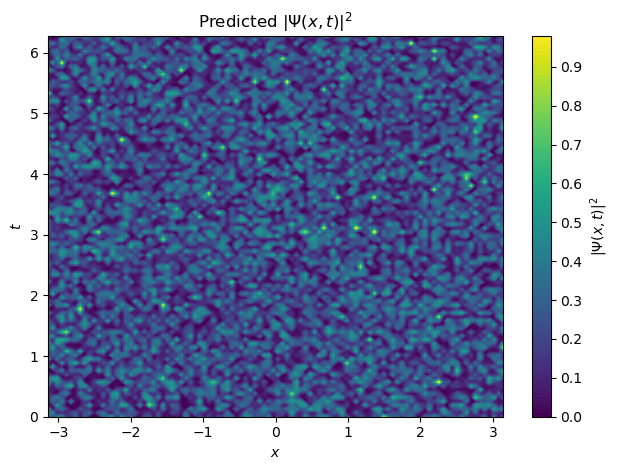

In [33]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

x_min, x_max = tf.constant(-np.pi, dtype=DTYPE), tf.constant(np.pi, dtype=DTYPE)
t_min, t_max = tf.constant(0, dtype=DTYPE), tf.constant(2*np.pi, dtype=DTYPE)

# data generation
N_f, N_b, N_i = 10000, 400, 500
# interior points
x_f = tf.random.uniform((N_f, 1), x_min, x_max, dtype=DTYPE)
t_f = tf.random.uniform((N_f, 1), t_min, t_max, dtype=DTYPE)
x_f_scaled = scale_inputs(x_f, x_min, x_max)
t_f_scaled = scale_inputs(t_f, t_min, t_max)

# Define the Neural Network
@tf.keras.utils.register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, **kwargs):
        super(PINN, self).__init__(**kwargs)
        initializer = tf.keras.initializers.HeNormal()
        self.dense1 = tf.keras.layers.Dense(256, activation='tanh', kernel_initializer=initializer)
        self.dense2 = tf.keras.layers.Dense(256, activation='tanh', kernel_initializer=initializer)
        self.dense3 = tf.keras.layers.Dense(256, activation='tanh', kernel_initializer=initializer)
        self.dense4 = tf.keras.layers.Dense(256, activation='tanh', kernel_initializer=initializer)
        self.dense5 = tf.keras.layers.Dense(2, activation='linear', kernel_initializer=initializer) # u_Re, u_Im
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)
        return x
    
    def get_config(self):
        config = super(PINN, self).get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Load the model
loaded_model = tf.keras.models.load_model('Schrodinger_equation_v2.keras', custom_objects={'PINN': PINN})
print("Model loaded successfully")

loaded_model.summary()

# Create a contour plot
x_plot = np.linspace(x_min, x_max, 100)
t_plot = np.linspace(t_min, t_max, 100)
X_grid, T_grid = np.meshgrid(x_plot, t_plot)  # t and x grid

input = tf.concat([x_f_scaled, t_f_scaled], axis=1)
uv = loaded_model(input)
u, v = uv[:, 0], uv[:, 1]
density = u**2 + v**2
density_grid = tf.reshape(density, X_grid.shape)

# # Convert tensors to numpy for plotting
# X_plot_np = X_grid.np()
# T_plot_np = T_grid.np()
density_grid_np = density_grid.numpy()


# plt.figure(figsize=(8, 5))
contour = plt.contourf(X_grid, T_grid, density_grid_np, levels=100, cmap="viridis")
plt.colorbar(contour, label=r'$|\Psi(x,t)|^2$')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'Predicted $|\Psi(x,t)|^2$')
plt.tight_layout()
plt.show()